In [1]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
seed = 1
file = open("test.txt", "w")
# for a year of weather data
for x in range(0, 365):
    timpeve = random.randint(0, 1)
    impeve = str(timpeve)
    tdecibel = random.randint(60, 70)
    decibel = str(tdecibel)
    halfa = random.randint(0, 23)
    halfb = random.randint(0, 59)
    if halfa == 0:
        if halfb < 10:
            time = "000" + str(halfb)
        else:
            time = "00" + str(halfb)
    else:
        if halfa < 10:
            if halfb < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = "0" + str(halfa) + str(halfb)

        elif halfb < 10:
            if halfa < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = str(halfa) + "0" + str(halfb)
        else:
            time = str(halfa) + str(halfb)
    tfail = random.randint(0, 1)
    fail = str(tfail)
    tanomaly = random.randint(0, 1)
    anomaly = str(tanomaly)
    file.write(impeve + " " + decibel + " " + fail + " " + time + " " + anomaly + "\n")
    random.seed()
file.close()

In [3]:
relevantWeatherData = pd.read_csv('888.csv');
relevantWeatherData = relevantWeatherData.drop(['WT01', 'WT02','WT03','WT04','WT05','WT06','WT08','WT09', 'AWND', 'TAVG', 'STATION', 'STATION_NAME'], axis = 1)
# now we have ['date','prcp', 'snow', 'tmax', and 'tmin' as our features]
# but we want to specify LABC weather data, for this example
# so we make a copy of the original dataframe
# and splice it to only include the weather data from Los Angeles
# these are rows 216 - 581 in our .csv file


labcWeather = relevantWeatherData[:]

labcWeather = labcWeather[214:580]

# we reset the index of every data value so that it can merge with our pseudo-random dataset
# 2016 was a leap year, so we have 366 entries

labcWeather = labcWeather.reset_index(drop=True)

labcWeather['SNOW'] = labcWeather['SNOW'].replace([-9999.0], 0.0)
print(labcWeather[0:6])

#Add a new column SNR(Signal Noise Ratio) using our formula y = -80x - 20
labcWeather['SNR'] = labcWeather['PRCP'].apply(lambda r: (r * -80) - 20)

       DATE  PRCP  SNOW  TMAX  TMIN
0  20160101  0.00   0.0    65    44
1  20160102  0.00   0.0    64    47
2  20160103  0.00   0.0    62    45
3  20160104  0.00   0.0    67    56
4  20160105  1.42   0.0    59    52
5  20160106  1.18   0.0    57    47


In [4]:
equipmentData = pd.read_csv('test.txt', sep=" ", header = None, names = ['ImpEvent', 'SigLvl', 'NearbyFail', 'Time', 'Anomaly'])
print(labcWeather)

         DATE  PRCP  SNOW  TMAX  TMIN    SNR
0    20160101  0.00   0.0    65    44  -20.0
1    20160102  0.00   0.0    64    47  -20.0
2    20160103  0.00   0.0    62    45  -20.0
3    20160104  0.00   0.0    67    56  -20.0
4    20160105  1.42   0.0    59    52 -133.6
5    20160106  1.18   0.0    57    47 -114.4
6    20160107  0.12   0.0    58    48  -29.6
7    20160108  0.00   0.0    61    47  -20.0
8    20160109  0.00   0.0    60    46  -20.0
9    20160110  0.01   0.0    60    51  -20.8
10   20160111  0.00   0.0    62    49  -20.0
11   20160112  0.00   0.0    67    45  -20.0
12   20160113  0.00   0.0    61    44  -20.0
13   20160114  0.00   0.0    62    51  -20.0
14   20160115  0.00   0.0    63    49  -20.0
15   20160116  0.00   0.0    63    54  -20.0
16   20160117  0.00   0.0    64    51  -20.0
17   20160118  0.01   0.0    62    54  -20.8
18   20160119  0.05   0.0    61    55  -24.0
19   20160120  0.01   0.0    64    56  -20.8
20   20160121  0.00   0.0    76    50  -20.0
21   20160

In [5]:
# x now contains the weather data in conjunction with the equipment data we created
x = pd.merge(left=labcWeather, right=equipmentData,left_index = True, right_index = True)
x[::91]

,DATE,PRCP,SNOW,TMAX,TMIN,SNR,ImpEvent,SigLvl,NearbyFail,Time,Anomaly
0,20160101,0.0,0.0,65,44,-20.0,1,68,0,1817,0
91,20160401,0.0,0.0,67,53,-20.0,0,68,1,2128,0
182,20160701,0.0,0.0,75,66,-20.0,0,62,1,1723,0
273,20160930,0.0,0.0,80,67,-20.0,0,68,0,1204,1
364,20161230,0.2,0.0,63,56,-36.0,1,65,0,548,1


In [6]:
# we have to normalize the values. 
# in this case, we normalize only the values we're going to use. Rain and Signal Power
prcpMax = x['PRCP'].max()
sigMax = x['SigLvl'].max()
snrMax = x['SNR'].max()
x['NormPRCP'] = x['PRCP'].apply(lambda y: y / prcpMax)
x['NormSIG'] = x['SigLvl'].apply(lambda z: z / sigMax)
x['NormSNR'] = x['SNR'].apply(lambda d: d/ snrMax)

In [7]:
x[::90]

,DATE,PRCP,SNOW,TMAX,TMIN,SNR,ImpEvent,SigLvl,NearbyFail,Time,Anomaly,NormPRCP,NormSIG,NormSNR
0,20160101,0.0,0.0,65,44,-20.0,1,68,0,1817,0,0.0,0.971429,1.0
90,20160331,0.0,0.0,66,49,-20.0,0,70,1,1213,0,0.0,1.000000,1.0
180,20160629,0.0,0.0,75,65,-20.0,0,67,1,1849,0,0.0,0.957143,1.0
270,20160927,0.0,0.0,96,72,-20.0,1,63,1,2030,0,0.0,0.900000,1.0
360,20161226,0.0,0.0,63,46,-20.0,0,61,1,2231,0,0.0,0.871429,1.0


<function matplotlib.pyplot.show>

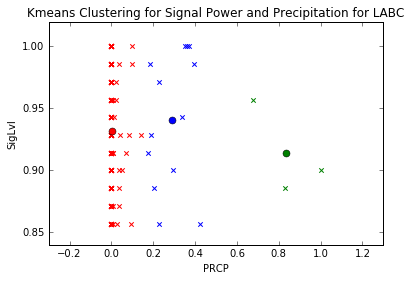

In [8]:
%matplotlib inline
kMeans = KMeans(n_clusters=3)
X = x[['NormPRCP', 'NormSIG']]
kMeans.fit(X)

# Assigned Labels after clustering: 
labels = kMeans.labels_

# Centers of the clusters:
centers = kMeans.cluster_centers_

plt.figure

for l, c in zip([0,1,2], ['red', 'blue', 'green']):
    
    current_members = (labels == l)
    current_center = centers[l]
    
    plt.scatter(X.iloc[current_members,0], X.iloc[current_members,1], color = c, marker='x')
    
    plt.plot(current_center[0], current_center[1], 'o', markerfacecolor = c,
            markeredgecolor = 'k', markersize=7)
    
plt.xlim([-0.3,1.3])

    
plt.xlabel('PRCP')
plt.ylabel('SigLvl')
plt.title('Kmeans Clustering for Signal Power and Precipitation for LABC')

plt.show

In [19]:
# std and mean for NORMALIZED values
# list which features to get std and mean
# for example, it wouldnt make sense to get std and mean of date and time
stdMeanFeats = ['PRCP', 'TMAX','TMIN','SigLvl', 'NormPRCP', 'NormSIG', 'NormSNR']
print(x[stdMeanFeats].std())
print()
print(x[stdMeanFeats].mean())

#NDvalues stores the normal distribution values of PRCP, then SNOW, then TMAX, etc.
i = 0
NDvalues = [0, 0, 0, 0, 0, 0, 0]
for name in stdMeanFeats:
    z = 0
    e = 2.71
    denominator = math.sqrt(2 * (math.pow(x[name].std(), 2)) * math.pi) 
    numeratorOfPower = math.pow((z - x[name].mean()), 2)
    denominatorOfPower = 2 * math.pow(x[name].std(), 2)
    power = numeratorOfPower / denominatorOfPower
    power *= -1
    finalbase = e / denominator
    NDvalues[i] = math.pow(finalbase, (power))
    i += 1

i = 0
print('\n')
print('Normal Distribution Values \n')
for value in NDvalues:
    print(str(stdMeanFeats[i]) + '      ' + str(NDvalues[i]))
    i += 1
finalValue = 1
for number in NDvalues:
    finalValue *= number
print()
print('Probability: ' + str(finalValue))


PRCP        0.134164
TMAX        7.482619
TMIN        6.319076
SigLvl      3.183620
NormPRCP    0.094481
NormSIG     0.045480
NormSNR     0.536655
dtype: float64

PRCP         0.027945
TMAX        71.953425
TMIN        57.841096
SigLvl      65.243836
NormPRCP     0.019680
NormSIG      0.932055
NormSNR      1.111781
dtype: float64


Normal Distribution Values 

PRCP      0.9557428442586611
TMAX      6.998356458083998e+38
TMIN      1.324517162423242e+32
SigLvl      3.132555461600818e+98
NormPRCP      0.9485003607231851
NormSIG      1.088136742716598e-289
NormSNR      0.2224522649121009

Probability: 6.371640745223904e-121
